In [2]:
from tslearn.generators import random_walks
from tslearn.clustering import KShape
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import gc
from tslearn.clustering import TimeSeriesKMeans,silhouette_score
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
TimeSeriesResampler

In [3]:
#讀檔&index重新排序
path = './Binance_BTCUSDT_hour.csv'
df = pd.read_csv(path)
df = df.reindex(-np.sort(-np.arange(len(df))))


In [4]:
#擷取⽇期及收盤價
df2 = df.loc[:, ('date', 'close')] ; del df ; gc.collect()
#切出⽇期時間欄位，符號統⼀
df2['NewDate'] = df2.loc[:, 'date'].str.slice(start = 0, stop = 10).str.replace('-', '/').str.rsplit(pat=' ', n=1).apply(lambda x : x[0])
#判斷⽇期欄位格式
df2['AMPM'] = df2.loc[:, 'date'].str.contains(pat = 'AM|PM')
#依⽇期欄位格式切分兩分DF，有AMPM的在df3，正常格式的在df4
df3 = df2[df2['AMPM'] == 1]
df4 = df2[df2['AMPM'] == 0]
del df2 ; gc.collect()

33

In [5]:
#切出⽇期欄位中的⼩時
df3['Hour'] = df3.loc[:, 'date'].str.slice(start = 10, stop = 13).str.replace(':', '').apply(lambda x : pd.to_numeric(x))
df3['AMPM'] = df3.loc[:, 'date'].str.slice(start = 14, stop = 16).apply(lambda x: 12 if (x == 'PM') else 0)
df3['24Hr'] = (df3['Hour'] + df3['AMPM'])
#轉換為24⼩時制
df3['24Hr'] = df3['24Hr'].apply(lambda x: (x == 24 and 12) or (x == 12 and '00') or x)
df3['24Hr'] = df3['24Hr'].apply(lambda x: '0'+str(x) if len(str(x)) == 1 else str(x))

#轉為時間格式
df3['NewDateTime'] = (df3['NewDate'] + ' ' +df3['24Hr'])
df3['NewDateTime'] = df3['NewDateTime'].apply(lambda x: pd.to_datetime(x, format = "%Y/%m/%d %H"))
#移除重複
df3 = df3[['close', 'NewDateTime']].drop_duplicates()
df3.head()

,close,NewDateTime
39631,4308.83,2017-08-17 04:00:00
39630,4315.32,2017-08-17 05:00:00
39629,4324.35,2017-08-17 06:00:00
39628,4349.99,2017-08-17 07:00:00
39627,4360.69,2017-08-17 08:00:00


In [6]:
#轉為時間格式並移除重複
df4['NewDateTime'] = df4['date'].apply(lambda x: pd.to_datetime(x, format = "%Y/%m/%d %H:%M"))
df4 = df4[['close', 'NewDateTime']].drop_duplicates()
df4.head()

,close,NewDateTime
13695,11801.17,2020-08-01 23:00:00
13693,11782.63,2020-08-02 00:00:00
13691,11942.55,2020-08-02 01:00:00
13689,11928.58,2020-08-02 02:00:00
13687,12000.00,2020-08-02 03:00:00


In [7]:
#合併df3、df4，並移除重複
df5 = pd.concat([df3, df4]) ; df6 = df5.drop_duplicates()
#確認刪除多少資料
print(len(df5), len(df6))
del (df3, df4, df5)
gc.collect()


39632 36984


0

In [8]:
#依照年份及週次分組
df6['Year'] = df6.loc[:, 'NewDateTime'].dt.year
df6['Week'] = df6.loc[:, 'NewDateTime'].dt.isocalendar().week
test = np.array(df6.groupby(['Year', 'Week']), dtype = object).T
#排除⻑度不為168的array
Array = np.empty([1, 168])
for i in range(0, len(np.array(test[1]))):
    if len(np.array(test[1][i]['close'])) == 168 :
        Array = np.append(Array, np.array(test[1][i]['close']).reshape(1, -1), axis = 0)

AttributeError: 'DatetimeProperties' object has no attribute 'isocalendar'

In [9]:
#Normalize
NArray = np.empty([1, 168])
for i in range(1, len(Array)):
    TempN = TimeSeriesScalerMeanVariance(mu=0.0, std=1.0).fit_transform(Array[i].reshape(1, -1)).reshape(1, -1)
    NArray = np.append(NArray, TempN, axis = 0)
    del TempN
#刪除第⼀個元素
NArray = NArray[1:207]
NArray[0]


NameError: name 'Array' is not defined

In [10]:
KME_DTW = []
for i in range(2, 8):
    ks = TimeSeriesKMeans(n_clusters=i, max_iter = 1, random_state=999, metric="euclidean")
    ypred = ks.fit_predict(NArray)
    TempDTW = silhouette_score(NArray, ypred, metric = 'euclidean')
    KME_DTW.append(TempDTW)
plt.plot(range(2, 8), KME_DTW, marker='o', color = 'blue')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.tight_layout()
plt.show()

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

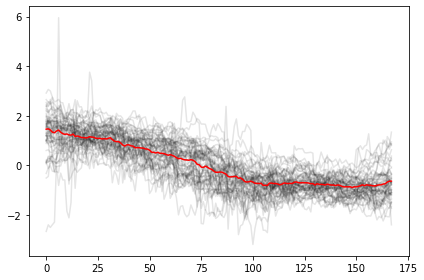

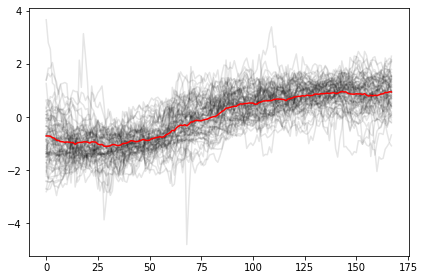

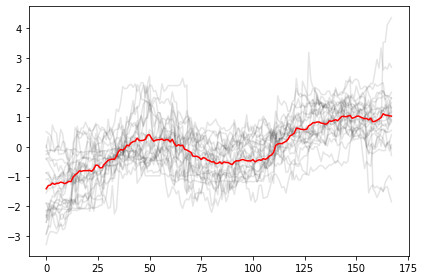

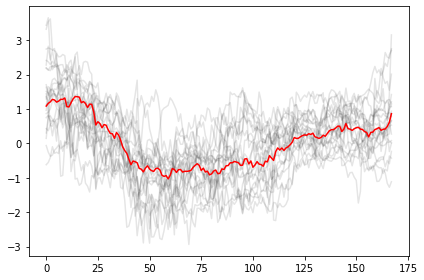

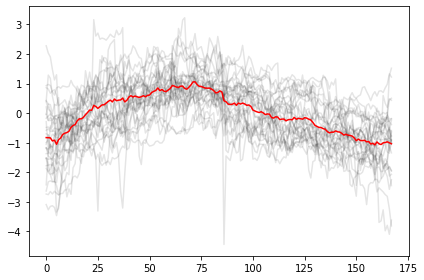

In [10]:
BestCluster = 5
ks_best = TimeSeriesKMeans(n_clusters=BestCluster, max_iter = 1, random_state=999)
y_pred = ks_best.fit_predict(NArray)
for yi in range(BestCluster):
    for xx in NArray[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.1)
    plt.plot(ks_best.cluster_centers_[yi].ravel(), "r-")
    # plt.text(0.85, 0.90, 'Cluster %d' % (yi + 1), transform=plt.gca
    plt.tight_layout()
    plt.show()

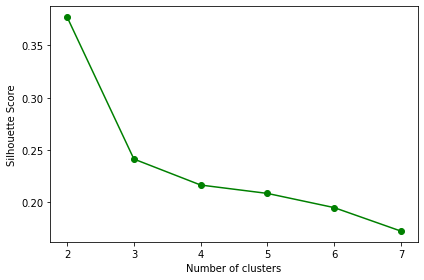

In [11]:
KM_EUC = []
for i in range(2, 8):
    ks = TimeSeriesKMeans(n_clusters=i, max_iter = 1, random_state=999, metric="euclidean")
    ypred = ks.fit_predict(NArray)
    NArray[0]
    ypred[0]
    TempEUC = silhouette_score(NArray, ypred, metric = 'euclidean')
    KM_EUC.append(TempEUC)
    
plt.plot(range(2, 8), KM_EUC, marker='o', color = 'green')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.tight_layout()
plt.show()


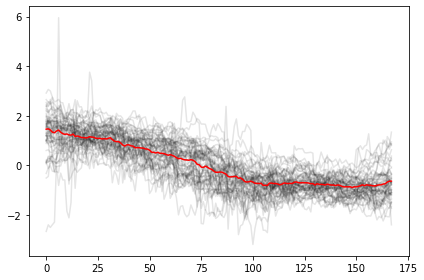

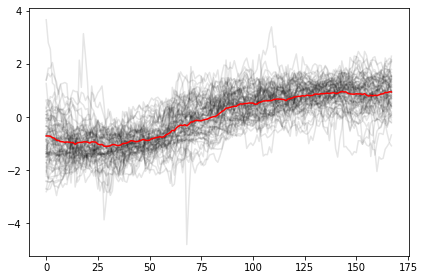

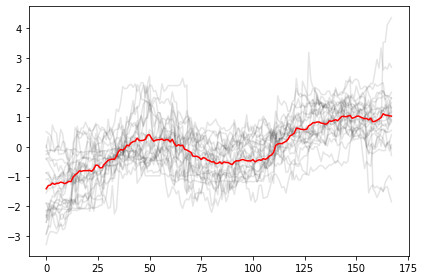

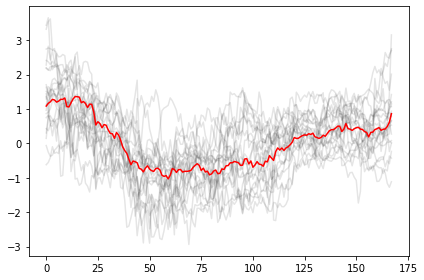

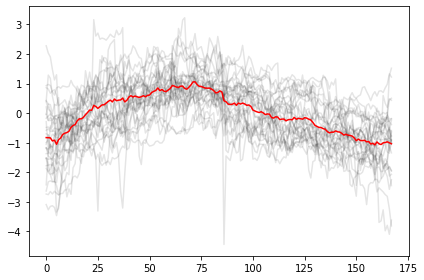

In [12]:
BestCluster = 5
ks_best = TimeSeriesKMeans(n_clusters=BestCluster, max_iter = 1, random_state=999)
y_pred = ks_best.fit_predict(NArray)
                           
for yi in range(BestCluster):
    for xx in NArray[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.1)
    plt.plot(ks_best.cluster_centers_[yi].ravel(), "r-")
#     plt.text(0.85, 0.90, 'Cluster %d' % (yi + 1), transform=plt.gca
    plt.tight_layout()
    plt.show()
